# Extension of GSCAN results to mQTL

**Author:** Jesse Marks

**GitHub Issue:**  [LIBD NAc mQTL Analysis #142](https://github.com/RTIInternational/bioinformatics/issues/142)

We have preliminary results from a very large-scale genome-wide study for cigarette smoking phenotypes that relate to our nicotine dependence GWAS results. See the supplemental Tables S6-S9 here: 

`smb://RTPNFIL02/dhancock/dhancock/Nicotine/Analysis/GSCAN/shared MS version 1/Supplementary_Tables_S6-S12_Loci.xlsx`

The phenotypes of interest to us include: 

1) **Age of smoking initiation (AI)** - supplemental table 6

2) **Cigarettes per day (CPD)** - supplemental table 7

3) **Smoking cessation (SC)** - supplemental table 8

4) **smoking initiation (SI)** - supplemental table 9

## Download Data
Create the directory structure and download the meta-analysis results to EC2. Also, create a list of SNPs for the lookup from the GSCAN Excel sheet. Copy the SNPs from each of the four Excel sheets (supplemental tables) into separate files and then combine them (no duplicates).

In [ ]:
## EC2 ##
# Create directory 
mkdir -p /shared/rti-nd/lookup/gscan/20210915/
cd /shared/rti-nd/lookup/gscan/20210915/

# populate these files with the SNPs from respective Excel sheets
# I just copy/pasted since there were not that many
touch table6_age_of_initiation.txt  table7_cig_per_day.txt  table8_smoking_cessation.txt  table9_smoking_initiation.txt

# make space separated (and use vim to edit header by adding underscores in header name when spaces are present in one field)
awk '$1=$1' table6_age_of_initiation.txt  > tmp && mv tmp table6_age_of_initiation.txt
awk '$1=$1' table7_cig_per_day.txt  > tmp && mv tmp table7_cig_per_day.txt
awk '$1=$1' table8_smoking_cessation.txt  > tmp && mv tmp table8_smoking_cessation.txt
awk '$1=$1' table9_smoking_initiation.txt  > tmp && mv tmp table9_smoking_initiation.txt

wc -l * # note these are with headers
"""
   11 table6_age_of_initiation.txt
   56 table7_cig_per_day.txt
   25 table8_smoking_cessation.txt
  377 table9_smoking_initiation.txt
"""

head table6_age_of_initiation.txt
"""
head table6_age_of_initiation.txt
Chr Pos rsID Reference_Allele Alternate_Allele
2 145638766 rs72853300 C T
2 225353649 rs12611472 T C
2 63622309 rs7559982 T A
3 85699040 rs11915747 C G
4 140908755 rs13136239 G A
"""

In [ ]:
## Download joint 2df results from the mQTL mapping
aws s3 sync s3://rti-nd/libd/results/methylation_qtl/strat_2df/maf_filtered_qtls/ .
    
head filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr10_cis_qtl_table.txt
#SNP     gene    case_beta       ctrl_beta       case_t_stat     ctrl_t_stat     case_p  ctrl_p  chisq_stat      chisq_p
#10:10001753:TAAAG:T     cg02458642      -0.824762223341344      0.331612703669845       -2.07465254377  1.6076694029    0.043899527866893       0.109879160224346      6.8887840864    0.03192416465703847
#10:10001753:TAAAG:T     cg02703020      -0.496341358240632      0.0797450361608843      -1.59883376047  0.448872731902  0.117014807406559       0.654130827296118      2.75775612306   0.2518609671122902

## SNP lookup
I need to create a dictionary of the GSCAN SNPs and then see if each SNP in the stratified 2df results.  

Also note that there are some SNPs in the mQTL mapping results which have the format of `chr:position:a1:a2` of  others of the form `rsid:position:a1:a2`. We can first try to just search for the ones with rsIDs. We may end up searching for them based on chr:position though if we can't find them. 

### Table 6: AI Loci

In [ ]:
### Python3 ###
"""
*SNP lookup*

    Make sure the IDs are of the same format for the snp-list
    and the IDs in the meta-analysis results. e.g. 1000g_p3 or rsID only
"""
import gzip

################################################################################
################################################################################

table = "table6_age_of_initiation" # no file extension
base_dir = "/shared/rti-nd/lookup/gscan/20210915"  # no forward slash at the end

## dict to hold gscan snps and the number of times they were found.
## we can tell which SNPs did not show up in any of the mqtl mapping files
snp_list = "{}/{}.txt".format(base_dir, table)
progress = "Processing {}".format(table)

out_file = "{}/lookup_results/2df_mqtl_mapping_{}_gscan_lookup.txt".format(base_dir, table)
not_found = "{}/lookup_results/2df_mqtl_mapping_{}_gscan_snps_not_found".format(base_dir, table)
head_line = "false" # write the header to out file then change to true so it won't print it again
with open(snp_list) as gscanF, open(out_file, "w") as outF:
    gscan_line = gscanF.readline()

    ## create a dictionary containing the gscan snps (rsIDs)
    gscan_dict =  {}
    gscan_posdict =  {} # some variants have depricated rsIDs, so we'll also search by position
    if len(gscan_dict) == 0:
        gscan_line = gscanF.readline() # 1st non-header line
        while gscan_line:
            # Chr Pos rsID Reference_Allele Alternate_Allele
            rsid = gscan_line.split()[2]
            position = gscan_line.split()[1]
            gscan_dict[rsid] = 0 # initiate the number of times it has been found
            gscan_posdict[position] = rsid
            gscan_line = gscanF.readline()
    print(gscan_dict)
    print(gscan_posdict)

    for chrom in range(1,22):
        which_chrom = "chr{}".format(chrom)
        print(which_chrom)
        mqtl_results = "{}/mqtl_mapping/filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr{}_cis_qtl_table.txt".format(base_dir, chrom)
        with open(mqtl_results) as mqtlF:
            mqtl_head = mqtlF.readline()
            if head_line == "false":
                outF.write(mqtl_head)
                head_line = "true"
                
            mqtl_line = mqtlF.readline()
            while mqtl_line: # look at all of the variety
                # SNP     gene    case_beta       ctrl_beta  ...    
                #2:100060310:C:CT        cg00151788      -0.20686045775319       -0.0148707568224241 ... 
                # rs72853300:145638766:C:T        cg27382459      0.0206777132739697      0.0305212347955355 ...
                #GA006823        cg00029583      0.237828601989225       0.0853544190919354  ...
                # rs1000007       cg00002145      -0.129089093196684      -0.0565450971892582  ...

                variant_id = mqtl_line.split()[0] # SNP
                if variant_id[0:2] == "rs":
                    if ":" in variant_id:
                        rs_id = variant_id.split(":")[0] # just the rsIDs
                        variant_pos = variant_id.split(":")[1] # just the position

                        if rs_id in gscan_dict:
                            gscan_dict[rs_id] += 1 # mark the variant as found
                            outF.write(mqtl_line)
                        elif variant_pos in gscan_posdict:
                            gscan_rs = gscan_posdict[variant_pos]
                            gscan_dict[gscan_rs] += 1 # mark the variant as found
                            outF.write(mqtl_line)
                    elif variant_id in gscan_dict:
                        gscan_dict[variant_id] += 1 # mark the variant as found
                        outF.write(mqtl_line)

                mqtl_line = mqtlF.readline()

with open(not_found, "w") as notF:
    notF.write("variant\n")
    for key, value in gscan_dict.items():
        if value==0:
            notF.write(key + "\n")

### Table 7: CPD Loci
Same as table6, just change file name.

### Table 8: SC Loci
Same as table6, just change file name.

### Table 9: SI Loci
Same as table6, just change file name.

## Report results in Excel
See the Excel Spreadsheet
`/Users/jmarks/OneDrive - Research Triangle Institute/Projects/nicotine/lookup/gscan/20210921/20210921_gscan_lookup_in_2df_mqtl_mapping.xlsx`

# Redo lookup with random SNPs: 20210923
```css
We’re getting a lot of significant results in here, which may reflect true biology or indicate some inflation. Can you pull a random set of 371 SNPs across the genome and repeat the lookup of QTL results?

Thanks,
Dana
```

Log into GOBOT sandbox server.

In [ ]:
mkdir -p ~/rti-nd/lookup/gscan/20210923/mqtls/

# download data
cd ~/rti-nd/lookup/gscan/20210923/mqtls/
aws s3 sync s3://rti-nd/libd/results/methylation_qtl/strat_2df/maf_filtered_qtls/ . --quiet

cd ../
# get header
head -1 mqtls/filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr1_cis_qtl_table.txt > \
    strat2df_cis_qtl_table_371_random_snps_across_genome.txt

# In order to get exactly 371 SNPs, we need to partition the chromosomes up.
# In particular, we will extract 17 random lines from 19 largest chromosomes,
# and 16 random lines from the 3 smallest chromosomes. This equals 371 total lines.
n=17
for chr in {1..19}; do
    file=mqtls/filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr${chr}_cis_qtl_table.txt
    shuf -n $N <(tail -n +2 $file) >> strat2df_cis_qtl_table_371_random_snps_across_genome.txt
done &

N=16
for chr in {20..22}; do
    file=mqtls/filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr${chr}_cis_qtl_table.txt
    shuf -n $N <(tail -n +2 $file) >> strat2df_cis_qtl_table_371_random_snps_across_genome.txt
done

# This could potentially output non-unique SNPs since some SNPs are present on multiple lines.
# Let's make sure that all 371 lines are unique. (372 with header)
cut -f1 strat2df_cis_qtl_table_371_random_snps_across_genome.txt  | sort -u | wc -l
# 372

################################################################################
################################################################################

### Now perform lookup of those SNPs

# paste those 371 SNPs into a file named snp_list.txt then perform lookup
### Python3 ###
"""
*SNP lookup*

    Make sure the IDs are of the same format for the snp-list
    and the IDs in the meta-analysis results. e.g. 1000g_p3 or rsID only
"""
import gzip

table = "snp_list" # no file extension
base_dir = "/gobot/jmarks/rti-nd/lookup/gscan/20210923"  # no forward slash at the end

## dict to hold gscan snps and the number of times they were found.
## we can tell which SNPs did not show up in any of the mqtl mapping files
snp_list = "{}/{}.txt".format(base_dir, table)
progress = "Processing {}".format(table)

out_file = "{}/results/2df_mqtl_mapping_{}_gscan_lookup.txt".format(base_dir, table)
head_line = "false" # write the header to out file then change to true so it won't print it again
with open(snp_list) as gscanF, open(out_file, "w") as outF:
    gscan_line = gscanF.readline()

    ## create a dictionary containing the gscan snps (rsIDs)
    gscan_dict =  {}
    if len(gscan_dict) == 0:
        gscan_line = gscanF.readline() # 1st non-header line
        while gscan_line:
            rsid = gscan_line.split()[0]
            gscan_dict[rsid] = 0 # initiate the number of times it has been found
            gscan_line = gscanF.readline()
    print(gscan_dict)

    for chrom in range(1,23):
        which_chrom = "chr{}".format(chrom)
        print(which_chrom)
        mqtl_results = "{}/mqtls/filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr{}_cis_qtl_table.txt".format(base_dir, chrom)
        with open(mqtl_results) as mqtlF:
            mqtl_head = mqtlF.readline()
            if head_line == "false":
                outF.write(mqtl_head)
                head_line = "true"

            mqtl_line = mqtlF.readline()
            while mqtl_line: # look at all of the variety
                variant_id = mqtl_line.split()[0] # SNP
                if variant_id in gscan_dict:
                    gscan_dict[variant_id] += 1 # mark the variant as found
                    outF.write(mqtl_line)

                mqtl_line = mqtlF.readline()

In [14]:
#17 * 19 + (16 * 3)
17 * 19


323

# 20220304 update
Redo the random SNP lookup except with 360 instead of 371. See message below for details. Note that we can just select 360 from the 371 random SNPs.

```
I found an issue with 11 SNPs in the GSCAN-meQTL lookup that we need to drop from the table. I discovered this while working on filling in the GSCAN SNP information.
 
In the attached spreadsheet you will see the 11 SNPs we need to drop. The error came from the script I wrote to pull these results. In particular, on SNPs for which I couldn’t find a matching rsID, I would then search by position – I didn’t restrict it to the particular chromosome the variant was from.
 
So for example, take the GSCAN SNP chr14:29316842:rs2145451. I added the rsID to a dictionary and the position to another dictionary. So then when the meQTL results had the SNP chr19:29316842:rs12609607 the algorithm first searched for the rsID. It didn’t find it so then it tried searching by position. Unfortunately there was a match by position, but it was for a different chromosome. Therefore, it is an erroneous match.
 
The intent of this algorithm was to pick up SNPs that were the same, but had different names. For example, the meQTL results had the SNP rs147137183 which was merged into rs12611472 in dbSNP144. You will see that I included two of these SNPs in the spreadsheet. I propose simply updating the names to their current rsID.
 
TL;DR
Remove 11 SNPs from results that were erroneously matched
Update the rsID for 2 SNPs
```

In [ ]:
cd /Users/jmarks/projects/nicotine/lookup/gscan/
mkdir -p 20220304/random_snps_lookup/
cd 20220304/random_snps_lookup/

# copy previous set of 371 random SNPs, just keep 360 though.
oldfile=../../20210924/strat2df_cis_qtl_table_371_random_snps_across_genome.txt
head -1 $oldfile > strat2df_cis_qtl_table_360_random_snps_across_genome.txt
shuf -n 360 <(tail -n +2 $oldfile) >> strat2df_cis_qtl_table_360_random_snps_across_genome.txt

# make sure all 360 variants are unique
cut -f1 strat2df_cis_qtl_table_360_random_snps_across_genome.txt  | sort -u | wc -l  # 361


# filter the previously found results based off of the 371 random SNPs

###python3
infile = "strat2df_cis_qtl_table_360_random_snps_across_genome.txt"
old_results = "/Users/jmarks/OneDrive - Research Triangle Institute/Projects/nicotine/lookup/gscan/20210924/results/2df_mqtl_mapping_snp_list_gscan_lookup.txt"
out_file = "/Users/jmarks/OneDrive - Research Triangle Institute/Projects/nicotine/lookup/gscan/20220304/random_snps_lookup/results/2df_mqtl_mapping_360_random_snp_lookup.txt"

with open(old_results) as oldR,  open(infile) as inF, open(out_file, 'w') as outF:
    head = inF.readline()
    print(head)

    snp_set = set()

    line = inF.readline()
    while line:
        sl = line.split()
        snp_set.add(sl[0])
        line = inF.readline()

    print(len(snp_set))

    head = oldR.readline()
    outF.write(head)
    line = oldR.readline()
    while line:
        sl = line.split()
        if sl[0] in snp_set:
            outF.write(line)
        line = oldR.readline()

In [ ]:
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220304/random_snps_lookup/original_random_371/
cp ls ../../../20210924/strat2df_cis_qtl_table_371_random_snps_across_genome.txt

# We know that chr1-19 are ordered and have 17 SNPs a piece.
# Followed by ordered chr20-22 with 16 SNPs a piece.
# We then just used vim to add a new column with chromosome info
vim strat2df_cis_qtl_table_371_random_snps_across_genome_with_chr.txt

cd /Users/jmarks/projects/nicotine/lookup/gscan/20220304/random_snps_lookup/snp_chr_distribution/

### python
infile1 = "../strat2df_cis_qtl_table_360_random_snps_across_genome.txt"
infile2 = "../original_random_371/strat2df_cis_qtl_table_371_random_snps_across_genome_with_chr.txt"
outfile = "strat2df_cis_qtl_table_360_random_snps_across_genome_with_chromosomes.txt"

with open(infile1) as inF1, open(infile2) as inF2, open(outfile, 'w') as outF:
    head = inF2.readline()
    print(head)
    outF.write(head)
    line = inF2.readline()
    data_dict = {}
    while line:
        sl = line.split()
        snp = sl[0]
        data_dict[snp] = line
        line = inF2.readline()

    head = inF1.readline()
    line = inF1.readline()
    while line:
        sl = line.split()
        snp = sl[0]
        if (snp in data_dict):
            outF.write(data_dict[snp])
        line = inF1.readline()

        

# sort by chromosome column        
sort -n -k11 strat2df_cis_qtl_table_360_random_snps_across_genome_with_chromosomes.txt >\
  strat2df_cis_qtl_table_360_random_snps_across_genome_with_chromosomes_sorted.txt

for chr in {1..22}; do
    echo -n "Chromosome $chr count:"
    awk -v chrom=$chr ' $11==chrom' *sorted.txt | ww
done

Chromosome 1 SNP count: 15
Chromosome 2 SNP count: 17
Chromosome 3 SNP count: 16
Chromosome 4 SNP count: 16
Chromosome 5 SNP count: 17
Chromosome 6 SNP count: 17
Chromosome 7 SNP count: 16
Chromosome 8 SNP count: 17
Chromosome 9 SNP count: 17
Chromosome 10 SNP count: 16
Chromosome 11 SNP count: 17
Chromosome 12 SNP count: 16
Chromosome 13 SNP count: 16
Chromosome 14 SNP count: 16
Chromosome 15 SNP count: 16
Chromosome 16 SNP count: 17
Chromosome 17 SNP count: 17
Chromosome 18 SNP count: 17
Chromosome 19 SNP count: 16
Chromosome 20 SNP count: 16
Chromosome 21 SNP count: 16
Chromosome 22 SNP count: 16

# 20220330 update: 3600 random SNP selection

**SNPsnap**
```
SNPsnap efficiently identifies sets of randomly drawn SNPs that are matched to a set of query SNPs based on

    Minor allele frequency
    Number of SNPs in linkage disequilibrium (LD buddies)
    Distance to nearest gene
    Gene density
```

Select 3600 random SNPs for a SNP enrichment test. Need to make sure the random SNPs:
* are in linkage equilibrium with each other
* are in linkage equilibrium with GSCAN.

**The approach we will take is as follows:**
1. Generated a host of random SNPs using the SNPsnap program.
2. Pull a set of ~4000 of those SNPs based on LD and their distribution across the genome to match the distribution of the 360 GSCAN SNPs.
3. Prune those ~4000 random SNPs down based on LD
4. Prune the 360 GSCAN SNPs down based on LD.
5. Combined the random LE SNPs and the GSCAN LE SNPs, then test for LD between these combined SNPs.<br>
    a. indicate that we would like to retain the GSCAN SNPs in the final pruned set.
6. Remove the 341 GSCAN SNPs from the resulting ld-pruned random+GSCAN set. Your left with just ~3,800 random SNPs.
7. Randomly select 3,600 of these SNPs.

## Create directory structure

In [ ]:
mkdir -p  /Users/jmarks/projects/nicotine/lookup/gscan/20220330/{choose_randoms,final_random_selection,gscan_360,libd_geno,snpsnap}

## Copy 360 unique GSCAN SNPs
Dana pointed me to a spreadsheet on Teams with these SNPs.

```css
Input the 360 unique GSCAN SNPs. Dana provided me these SNPs in the Excel speadsheet
https://researchtriangleinstitute-my.sharepoint.com/:x:/g/personal/dhancock_rti_org/EValePp-NOBLskMIZuONehwBSgjtI54MAX395SgNohmj3Q

See column N in "UniqueSNPsTested".
```

Note that Dana manually updated the rsIDs for SNPs rs28813180 and rs12611472. 
We end up manually changing these back to their deprecated IDs
rs28813180 -> rs138279803
rs12611472 -> rs147137183

So that we can match the LIBD data. The LIBD data has the old IDs instead of the new IDs.

In [ ]:
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/gscan_360

# use vim and paste the 360 SNPs into the following file
touch gscan_360.txt

## Run SNPsnap

https://data.broadinstitute.org/mpg/snpsnap/match_snps.html

Input the 360 unique GSCAN SNPs. Dana provided me these SNPs in the Excel speadsheet
https://researchtriangleinstitute-my.sharepoint.com/:x:/g/personal/dhancock_rti_org/EValePp-NOBLskMIZuONehwBSgjtI54MAX395SgNohmj3Q

See column N in "UniqueSNPsTested".

Use default of 10K random SNPs for each input SNP. Relax the locus definition distance cut-off and the SNP Matching Criteria to retain more random SNPs.

### Download SNPsnap results
Note that rs28813180 rs12611472
should have been found. These are the updated variant names. SNPsnap must not have the latest version of dbSNP for all of its SNPs.

In [ ]:
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/snpsnap/
unzip SNPsnap_360_gscan_input_v03.zip

# note that 4 SNPs of the 360 were not found
head input_snps_excluded.txt
#6:29796685	SNP_in_HLA_region
#rs28813180	SNP_not_found_in_data_base
#rs12611472	SNP_not_found_in_data_base
#rs11898717	SNP_not_found_in_data_base

## Get list of LIBD SNPs with rsids

In [ ]:
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/libd_geno/

# download plink files from mcarnes cluster
scp -i ~/.ssh/gwas_rsa ec2-user@54.157.10.254:/shared/mcarnes/geno/mQTL_subsets/* .

In [ ]:
### python3
"""
Create a list of SNPs with rsIDs from the LIBD genotype data.
"""

infile = "LIBD_NAc_AA.bim"
outfile = "aa_libd_variant_ids_and_rsid.txt"

with open(infile) as inF, open(outfile, 'w') as outF:
    line = inF.readline()
    print(line)   # 1  1:66381:TATATA:AATATA  0  66381  AATATA  TATATA

    libd_set = set()
    while line: # loop through all SNPs
        sl = line.split()
        snp = sl[1]; pos = sl[3]; chrom = sl[0]
        rsid = snp.split(":")[0]
        chrom_pos = "\t{}:{}".format(chrom,pos)
        
        # keep only SNPs with an rsID
        if rsid[0:2] == "rs":
            if rsid not in libd_set:
                libd_set.add(rsid)
                outF.write(rsid + chrom_pos + "\n")
        line = inF.readline()

## Select subset of random SNPs
In the end we want 3600 random SNPs, but some of the random SNPs we pull will be in LD. So we will pull more than 3600 so that when we perform LD we will still have >3,600 SNPs to choose from.

In [ ]:
### python3
"""
Select subset of random SNPs from the large set of 356×10,000 random SNPs.
4 SNPs from the 360 were not found in the SNPsnap program. 

Select 13 random SNPs for every input SNP for a total of
13×356 = 4,628 random SNPs

Check to make sure the random SNP is actually in the LIBD genotype data. Use the 
rsID list we created earlier.

Make sure you don't select a random SNP more than once.
"""

infile = "/Users/jmarks/projects/nicotine/lookup/gscan/20220330/snpsnap/SNPsnap_360_gscan_input_v03/matched_snps.txt"
outfile = "matched_4628_random_snps.txt"
libd_list = "/Users/jmarks/projects/nicotine/lookup/gscan/20220330/libd_geno/aa_libd_variant_ids.txt"

with open(infile) as inF, open(libd_list) as libdF, open(outfile, 'w') as outF:
    line = libdF.readline()
    print(line) # rs140435168:256586:T:G  1:256586

    libd_dict = dict()
    # make sure the random SNPs we pick are actually in the LIBD genotype data
    while line:
        sl = line.split()
        libd_dict[sl[1]] = sl[0] # chr:pos=key  rsid=value 
        line = libdF.readline()


    head = inF.readline()
    outhead = "gscan_snp\trandom_id\trandom_rsid\n"
    outF.write(outhead)
    line = inF.readline()

    dup_set = set() # make sure not to pick a random SNP >1 time
    while line: # loop thru all 360 (really just 356) GSCAN SNPs
        sl = line.split()
        gscan_snp = sl[0] # chr:pos
        gscan_chr = gscan_snp.split(":")[0]

        count = 0 # stop after 13 random SNPs found
        for i in range(1, len(sl)): # loop thru all 10K potential random SNPs
            random_snp = sl[i] # chr:pos
            random_chr = random_snp.split(":")[0]

            # random SNP is on same chromosome, not already picked, and in the LIBD genotypes
            if (random_chr == gscan_chr) and \
               (random_snp not in dup_set) and \
               (random_snp in libd_dict):
                dup_set.add(random_snp) # add to our random SNP set so we don't choose it again.
                outline = "{}\t{}\t{}\n".format(gscan_snp, random_snp, libd_dict[random_snp])
                outF.write(outline)
                count += 1
            if count == 13:
                break
        if count < 13: # make sure all 10 random SNPs were found for each of the GSCAN 360 SNPs
            print(gscan_snp)
        line = inF.readline()



## LD-prune the random SNPs
Started with 4,628 and ended with 3,938.

In [ ]:
num=4628 # initial number of randoms

cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/choose_randoms/

# extract just the variant IDs (the way they appear in LIBD) for Plink 
tail -n +2 matched_${num}_random_snps.txt | \
    cut -f3 > matched_${num}_random_snps_to_extract.txt
        
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/


# use plink2 to extract those SNPs from the 
docker run -v $PWD/:/data/ -it rtibiocloud/plink:v2.0_c6004f7 plink2 \
    --memory 2000 \
    --bfile /data/libd_geno/LIBD_NAc_AA \
    --extract /data/choose_randoms/matched_${num}_random_snps_to_extract.txt \
    --indep-pairwise 1500 150 0.2 \
    --out /data/choose_randoms/ldprune/libd_${num}_random_matched_ld_pruned_chrall
    
wc -l choose_randoms/ldprune/libd_4628_random_matched_ld_pruned_chrall.prune.in # 3938 total LE SNPs

## LD-prune the GSCAN360 SNPs

In [ ]:
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/
docker run -v $PWD/:/data/ -it rtibiocloud/plink:v2.0_c6004f7 plink2 \
    --memory 2000 \
    --bfile /data/libd_geno/LIBD_NAc_AA \
    --extract /data/gscan_360/gscan_360.txt \
    --indep-pairwise 1500 150 0.2 \
    --out /data/gscan_360/ldprune/libd_matched_with_gscan360_ld_pruned_chrall
    
wc -l gscan_360/ldprune/libd_matched_with_gscan360_ld_pruned_chrall.prune.in # 344 total LE SNPs

## LD-prune combined GSCAN and random SNPs
Combine the LD-pruned GSCAN SNPs with the LD-pruned random SNPs. Then perform LD-pruning again to ensure that none of the random SNPs are in LD with the GSCAN SNPs.

Specify that the GSCAN SNPs have preference so that none of them will be removed during the ld-pruning. Then we will have a list of LD-pruned SNPs that contain all of the LD-pruned GSCAN SNPs plus the random SNPs that are not in LD with these GSCAN SNPs nor with each other. We then remove the GSCAN SNPs from this pruned list and we are left with just what we were after - a set of random SNPs that are not in LD with each other nor GSCAN. Then we can take a random sample of 3,600 from this list to get exactly the number we were after.

In [ ]:
# combine random 3,938 LE SNPs with GSCAN 344 LE SNPs
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/final_random_selection/

cat /Users/jmarks/projects/nicotine/lookup/gscan/20220330/gscan_360/ldprune/libd_matched_with_gscan360_ld_pruned_chrall.prune.in \
    /Users/jmarks/projects/nicotine/lookup/gscan/20220330/choose_randoms/ldprune/libd_4628_random_matched_ld_pruned_chrall.prune.in \
    > gscan344_and_3938random_snps.txt # 4,282


# perform LD pruning to make sure random + GSCAN are not in LD
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/

# keep all the GSCAN SNPs
docker run -v $PWD/:/data/ -it rtibiocloud/plink:v2.0_c6004f7 plink2 \
    --memory 2000 \
    --bfile /data/libd_geno/LIBD_NAc_AA \
    --extract /data/final_random_selection/gscan344_and_3938random_snps.txt \
    --indep-pairwise 1500 150 0.2 \
    --indep-preferred /data/gscan_360/ldprune/libd_matched_with_gscan360_ld_pruned_chrall.prune.in \
    --make-bed \
    --out /data/final_random_selection/ldprune/gscan344_and_3938random_snps_ldpruned
    
wc -l final_random_selection/ldprune/gscan344_and_3938random_snps_ldpruned.prune.in # 4188
    
# remove the GSCAN SNPs from the final merged ldpruned output
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/final_random_selection/
grep --invert-match -f ../gscan_360/ldprune/libd_matched_with_gscan360_ld_pruned_chrall.prune.in \
    ldprune/gscan344_and_3938random_snps_ldpruned.prune.in > \
    random_snps3844_ld_pruned.txt

wc -l random_snps3844_ld_pruned.txt # 3844

#subset those down to 3600 SNPs using a random selection
N=3600
file=/Users/jmarks/projects/nicotine/lookup/gscan/20220330/final_random_selection/random_snps3844_ld_pruned.txt
shuf -n $N $file > final_random_snps3600_ld_pruned.txt

wc -l final_random_snps3600_ld_pruned.txt # 3600

head final_random_snps3600_ld_pruned.txt
#rs1902313:5052390:A:G
#rs57058278:80698492:T:C
#rs250546:13230705:T:G
#rs9842650
#rs2074046:44025648:T:A
    
# capture the chromosomes for each of these 3600 SNPs
grep -f final_random_snps3600_ld_pruned.txt ldprune/gscan344_and_3938random_snps_ldpruned.bim > \
    final_random_snps3600_ld_pruned.bim

## Distribution across genome
Plot the distribution of SNPs across the genome for each chromosome for:
* GSCAN 360
* 3,600 random SNPs

In [2]:
library(ggplot2)
options(repr.plot.width=20, repr.plot.height=10)
#options(repr.plot.width = 1, repr.plot.height = 0.75, repr.plot.res = 100)

Saving 7 x 7 in image



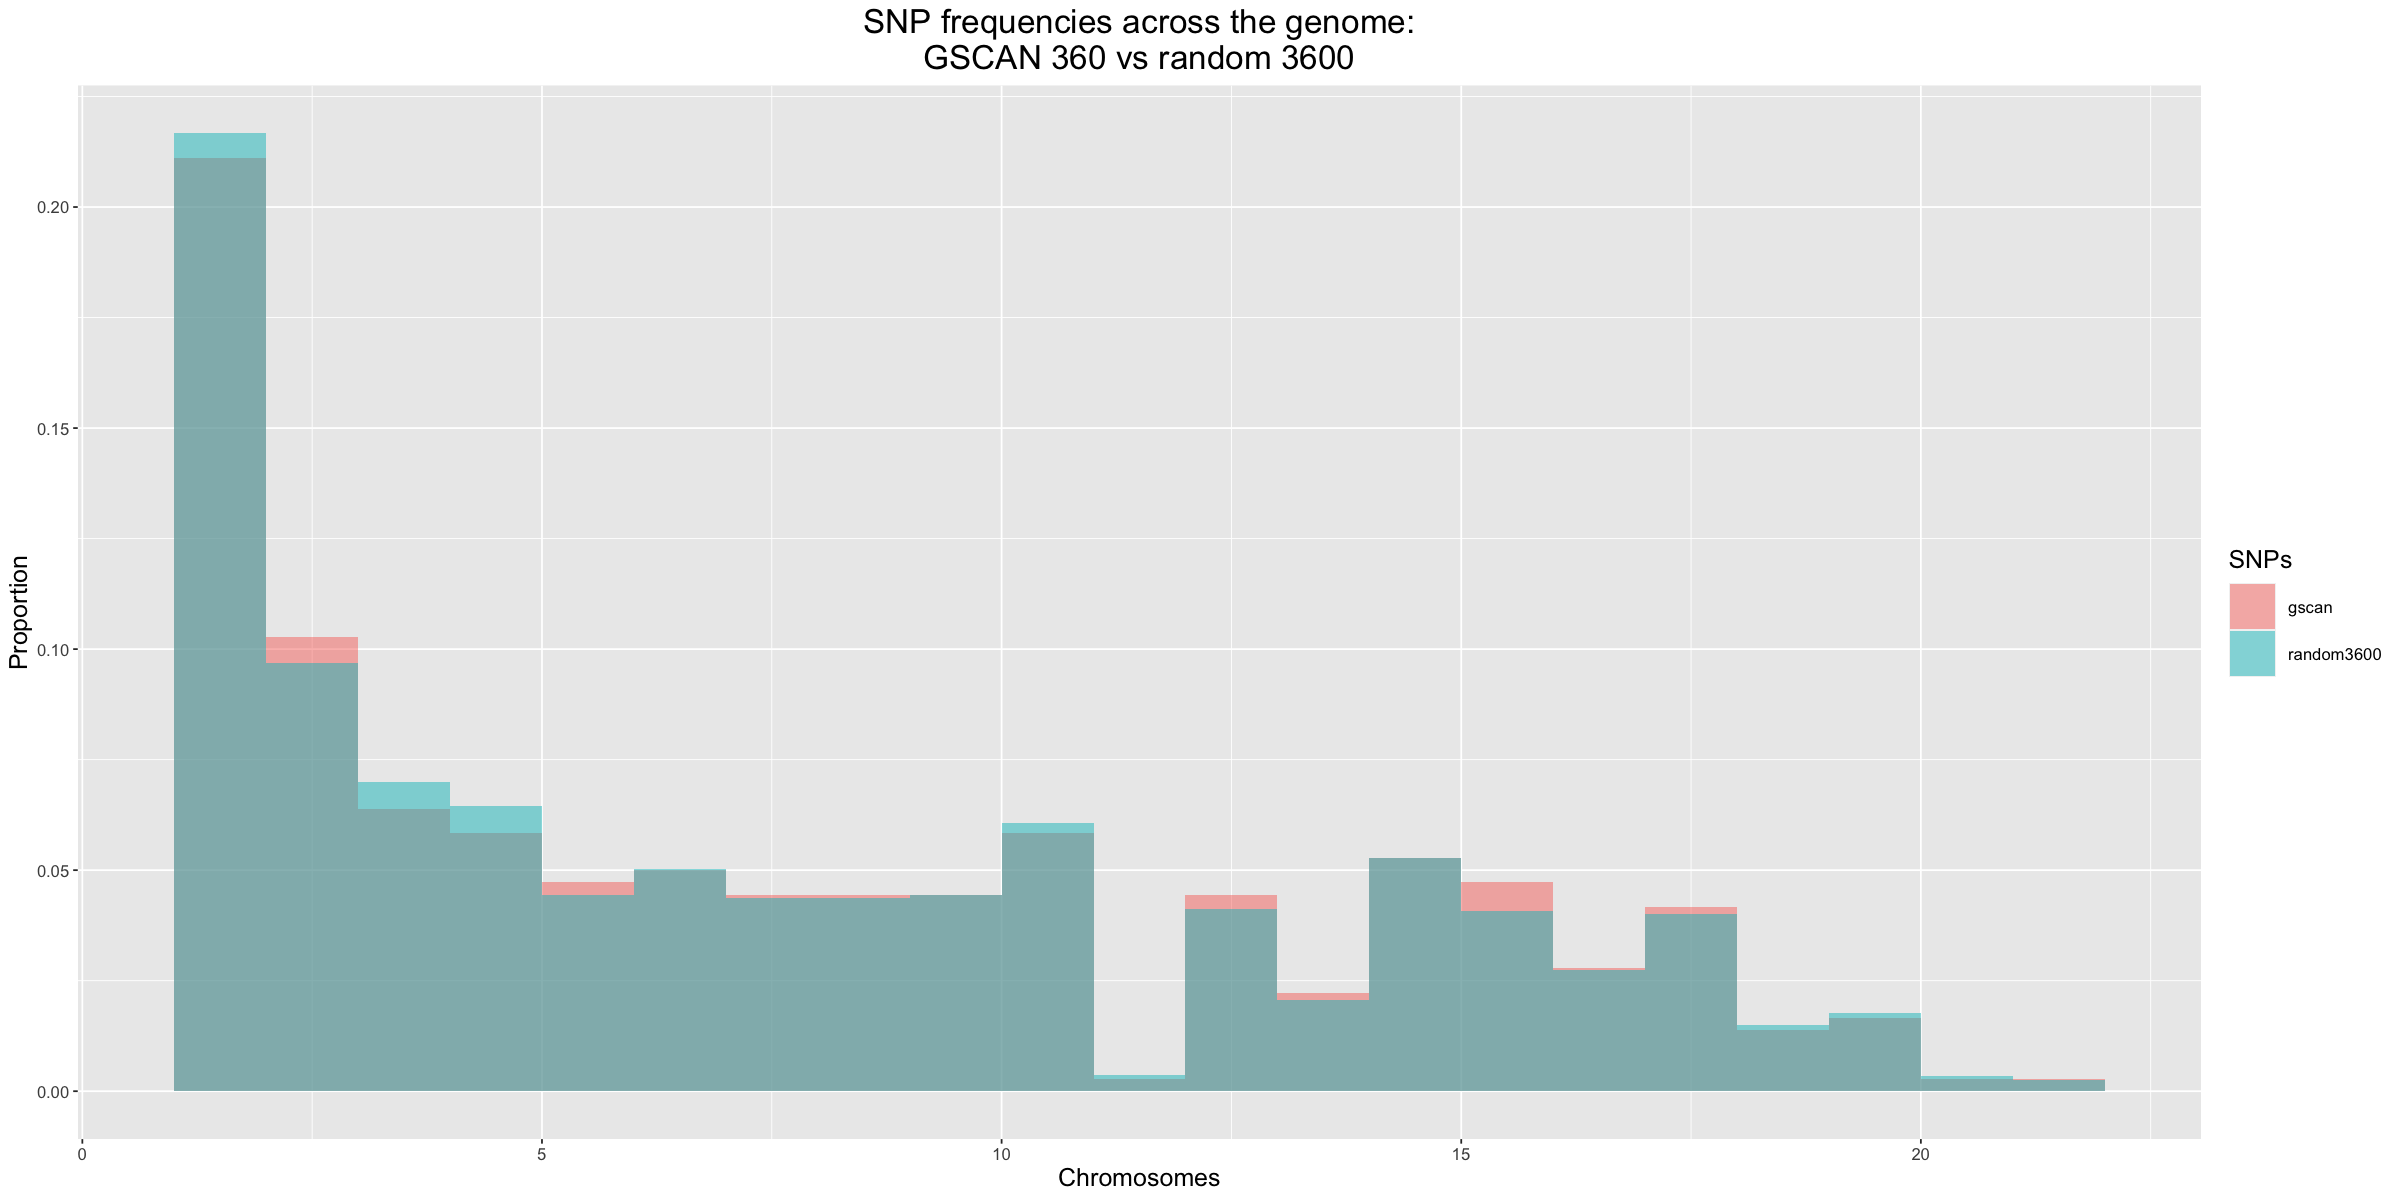

In [153]:
setwd("/Users/jmarks/projects/nicotine/lookup/gscan/20220330/snpsnap/SNPsnap_360_gscan_input_v03")
gscan360 <- read.delim("input_snps_annotated.txt")
setwd("/Users/jmarks/projects/nicotine/lookup/gscan/20220330/final_random_selection/")
random3600 <- read.delim("final_random_snps3600_ld_pruned.bim", header = FALSE)
names(random3600)[1] <- "chr"
#random3600 <- random3600$chr

gscan_chroms <- data.frame(do.call('rbind', strsplit(gscan360$snpID,':',fixed=TRUE)))
names(gscan_chroms) <- c("chr", "pos")

# add manually the missing SNPs  6:29796685 rs28813180 (3:158083918 (GRCh37)) rs12611472 (2:225353649 (GRCh37)) rs11898717 (2:72752073 (GRCh37))
missing <- data.frame(chr = c(6, 3, 2, 2), pos=c(29796685 , 158083918, 225353649, 72752073))
gscan_all <- rbind(gscan_chroms, missing)
gscan_all$chr <- as.integer(gscan_all$chr)
#gscan_all <- gscan_all$chr

# just use dbSNP to find the chr pos
gscan_all$SNPs = "gscan"
random3600$SNPs = "random3600"
#head(gscan_all)

combined_data <- rbind(gscan_all[, c("chr", "SNPs")], random3600[, c("chr", "SNPs")])
#head(combined_data)



# look into the plot where you can overlay them.

snp_histogram <- ggplot(data=combined_data, aes(chr, fill = SNPs)) +  
    #scale_fill_manual(values = c('#855C75', '#D9AF6B', '#AF6458', '#736F4C', '#526A83', '#625377', '#68855C')) +
    #scale_fill_manual(values = c('#AF6458',  '#68855C')) +
       geom_histogram(breaks=seq(1, 22, by=1),
                     alpha = .5,
                      #position = "dodge",
                      position = "identity",
                     aes(y = ..density..)) +
    labs(title="SNP frequencies across the genome:\nGSCAN 360 vs random 3600",
         x = "Chromosomes", y = "Proportion") + theme(axis.text.x=element_text(size=10),
                                   axis.text.y=element_text(size=10),
                                   axis.title.x=element_text(size=15),
                                   axis.title.y=element_text(size=15),
                                   plot.title = element_text(size=20, hjust = 0.5),
                                   legend.key.size = unit(1, 'cm'),
                                   legend.title = element_text(size=15), #change legend title font size
                                   legend.text = element_text(size=10)) #change legend text font size) 

snp_histogram
plotname <- "20220406_gscan_and_3600random_snp_proportions.png"
ggsave( filename=plotname, snp_histogram)

,chr,SNPs
,<int>,<chr>
1,1,random3600
2,1,random3600
3,1,random3600
4,1,random3600
5,1,random3600
6,1,random3600


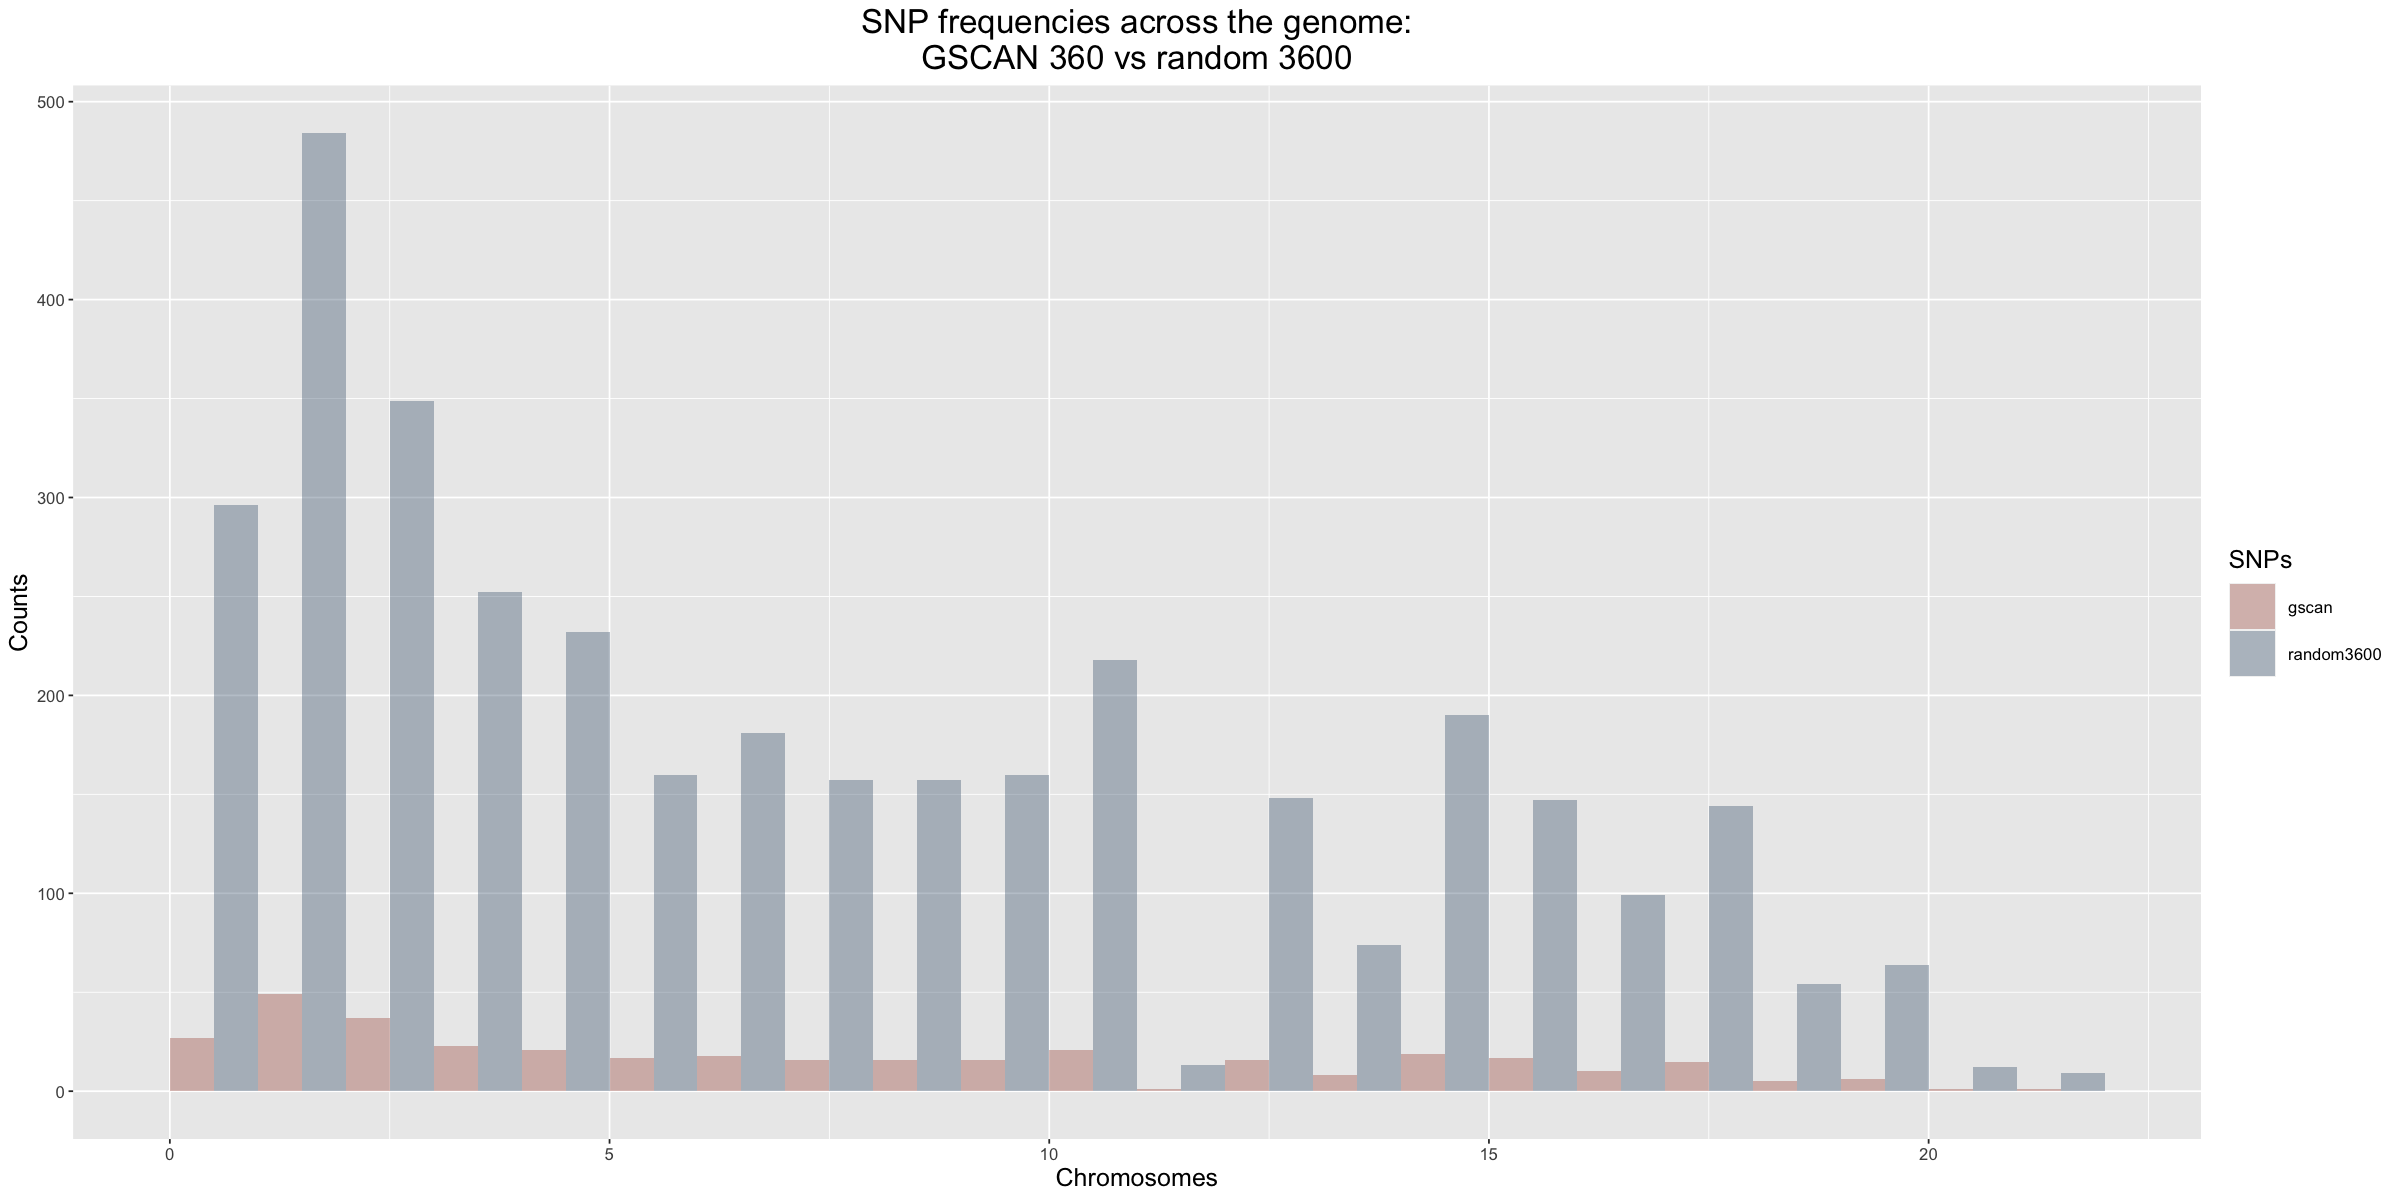

In [161]:
setwd("/Users/jmarks/projects/nicotine/lookup/gscan/20220330/snpsnap/SNPsnap_360_gscan_input_v03")
gscan360 <- read.delim("input_snps_annotated.txt")
setwd("/Users/jmarks/projects/nicotine/lookup/gscan/20220330/final_random_selection/")
random3600 <- read.delim("final_random_snps3600_ld_pruned.bim", header = FALSE)
names(random3600)[1] <- "chr"
#random3600 <- random3600$chr

gscan_chroms <- data.frame(do.call('rbind', strsplit(gscan360$snpID,':',fixed=TRUE)))
names(gscan_chroms) <- c("chr", "pos")

# add manually the missing SNPs  6:29796685 rs28813180 (3:158083918 (GRCh37)) rs12611472 (2:225353649 (GRCh37)) rs11898717 (2:72752073 (GRCh37))
missing <- data.frame(chr = c(6, 3, 2, 2), pos=c(29796685 , 158083918, 225353649, 72752073))
gscan_all <- rbind(gscan_chroms, missing)
gscan_all$chr <- as.integer(gscan_all$chr)
#gscan_all <- gscan_all$chr

# just use dbSNP to find the chr pos
gscan_all$SNPs = "gscan"
random3600$SNPs = "random3600"
#head(gscan_all)

#combined_data <- rbind(gscan_all[, c("chr", "SNPs")], random3600[, c("chr", "SNPs")])
combined_data <- rbind(random3600[, c("chr", "SNPs")], gscan_all[, c("chr", "SNPs")])
head(combined_data)



# look into the plot where you can overlay them.
#snp_histogram <- ggplot(data=combined_data, aes(x=chr, fill = SNPs, color = SNPs)) +
snp_histogram <- ggplot(data=combined_data, aes(x=chr, fill = SNPs )) +
    #scale_fill_manual(values = c('#855C75', '#D9AF6B', '#AF6458', '#736F4C', '#526A83', '#625377', '#68855C')) +
    scale_fill_manual(values = c('#AF6458',  '#526A83')) +
       geom_histogram(breaks=seq(0, 22, by=1),
                      #position = "stack",
                      #position = "identity",
                      #position = position_stack(reverse = TRUE),
                      position = "dodge",
                      #color = "#e9ecef",
                      alpha = .4) +
                     #scale_fill_brewer(palette = 10) +
    labs(title="SNP frequencies across the genome:\nGSCAN 360 vs random 3600",
         x = "Chromosomes", y = "Counts") + theme(axis.text.x=element_text(size=10),
                                   axis.text.y=element_text(size=10),
                                   axis.title.x=element_text(size=15),
                                   axis.title.y=element_text(size=15),
                                   plot.title = element_text(size=20, hjust = 0.5),
                                   legend.key.size = unit(1, 'cm'),
                                   legend.title = element_text(size=15), #change legend title font size
                                   legend.text = element_text(size=10)) #change legend text font size) 

snp_histogram
#plotname <- "20220406_gscan_and_3600random_snp_proportions.png"
#ggsave( filename=plotname, snp_histogram)

# Random 3600 SNP lookup in strat2df results
Like I did for the original GSCAN SNPs, create a table for the lookup of these 3600 random SNPs in the stratified 2df mQTL results.

Login to sandbox since these 

In [ ]:
# upload 3600 random to sandbox from local
cd /Users/jmarks/projects/nicotine/lookup/gscan/20220330/final_random_selection
scp -i ~/.ssh/id_rsa final_random_snps3600_ld_pruned.txt jmarks@13.58.211.184:/gobot/jmarks/rti-nd/lookup/gscan/20220406/

ssh sandbox

# Download results
mkdir -p ~/rti-nd/lookup/gscan/20220406/{maf_filtered_qtls,lookup_results}/
cd ~/rti-nd/lookup/gscan/20220406/maf_filtered_qtls

aws s3 sync s3://rti-nd/libd/results/methylation_qtl/strat_2df/maf_filtered_qtls/ .
    
zcat filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr10_cis_qtl_table.txt.gz | head -3
#SNP     gene    case_beta       ctrl_beta       case_t_stat     ctrl_t_stat     case_p  ctrl_p  chisq_stat      chisq_p
#10:10001753:TAAAG:T     cg02458642      -0.824762223341344      0.331612703669845       -2.07465254377  1.6076694029    0.043899527866893       0.109879160224346      6.8887840864    0.03192416465703847
#10:10001753:TAAAG:T     cg02703020      -0.496341358240632      0.0797450361608843      -1.59883376047  0.448872731902  0.117014807406559       0.654130827296118      2.75775612306   0.2518609671122902

In [ ]:
### Python3 ###
"""
*SNP lookup*

Search for the random 3600 SNPs within the maf_filtered_qtls LIBD results.
Note that there will likely be some random SNPs that don't appear in the LIBD results 
due to the MAF threshold applied to the mQTL results, or some other reason. 
We will record these missing SNPs.
"""
import gzip

################################################################################
################################################################################

base_dir = "/gobot/jmarks/rti-nd/lookup/gscan/20220406"  # no forward slash at the end
snp_list = "{}/final_random_snps3600_ld_pruned.txt".format(base_dir)

## dictionary to hold 3600 random snps and the number of times they were found.
out_file = "{}/lookup_results/2df_mqtl_mapping_3600_random_lookup.txt".format(base_dir)
not_found = "{}/lookup_results/2df_mqtl_mapping_3600_random_snps_not_found".format(base_dir)
head_line = "false" # write the header to out file then change to true so it won't print it again
with open(snp_list) as randomF, open(out_file, "w") as outF:
    line = randomF.readline()

    ## create a dictionary containing the random snps (rsIDs)
    random_dict =  {}
    while line:
        snp = line.strip()
    random_dict[snp] = 0 # initiate the number of times it has been found
    line = randomF.readline()


    for chrom in range(1,23):
        which_chrom = "chr{}".format(chrom)
        print(which_chrom)
        mqtl_results = "{}/maf_filtered_qtls/filtered_MAF_gte_0.05_sorted_LIBD_NAc_MEGA_strat2df_new_model_chr{}_cis_qtl_table.txt.gz".format(base_dir, chrom)

        with gzip.open(mqtl_results) as mqtlF:
            mqtl_head = mqtlF.readline()
            print(mqtl_head)
            if head_line == "false":
                outF.write(mqtl_head)
                head_line = "true"

            mqtl_line = mqtlF.readline()
            while mqtl_line: # look at all of the variety
                variant_id = mqtl_line.split()[0] # SNP
                # SNP     gene    case_beta       ctrl_beta ...
        #1:100048109:GA:G        cg00159212      0.171121853512045       -0.0596788572391956 ...
        if variant_id in random_dict:
                    random_dict[variant_id] += 1 # mark the variant as found   
                    outF.write(mqtl_line)
                mqtl_line = mqtlF.readline()


with open(not_found, 'w') as notF:
    for item in random_dict.items():
        count = item[1]
        if count == 0:
            notF.write(item[0])

